# Cài đặt các thư viện cần thiết

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.41.0 transformers==4.33.1 trl==0.4.7

# Import thư viện

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer

2024-05-18 13:54:58.858698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 13:54:58.858807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 13:54:59.023121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Tải dataset

In [ ]:
model_name = "google-t5/t5-large"

dataset_name = "memray/openkp"

new_model = "t5-large-fine-tune"

In [ ]:
dataset = load_dataset(dataset_name, split=['train[:15%]', 'test[:20%]'])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

[Dataset({
     features: ['url', 'text', 'KeyPhrases'],
     num_rows: 20234
 }),
 Dataset({
     features: ['url', 'text', 'KeyPhrases'],
     num_rows: 1323
 })]

# Tải tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

# Tiền xử lý dữ liệu

In [ ]:
train_dataset = dataset[0]
test_dataset = dataset[1]

def preprocess(data):
  inputs = [i for i in data['text']]
  targets = ['; '.join(i) for i in data['KeyPhrases']]
  model_inputs=tokenizer(inputs, padding=True, truncation=True)
  labels=tokenizer(targets,padding=True, truncation=True)

  model_inputs["labels"]=labels["input_ids"]
  return model_inputs

train_dataset=train_dataset.map(preprocess, batched=True)
test_dataset=test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/20234 [00:00<?, ? examples/s]

Map:   0%|          | 0/1323 [00:00<?, ? examples/s]

# Tải model T5-large

In [ ]:
device_map = {"": 0}

In [ ]:
# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# double quantization
use_nested_quant = False

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Khởi tạo tham số LoRA

In [ ]:
# Freeze the original parameters
model=prepare_model_for_kbit_training(model)

lora_r = 32
lora_alpha = 24
lora_dropout = 0.1

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    task_type="SEQ_2_SEQ_LM",
)

peft_model=get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 9,437,184 || all params: 495,447,040 || trainable%: 1.9047815887647648


# Training

In [ ]:
from transformers import DataCollatorForSeq2Seq

label_pad_token_id = tokenizer.pad_token_id

# padding the sentence of the entire datasets
data_collator=DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=peft_model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [ ]:
# Output directory where the model predictions and checkpoints will be stored
output_dir = "/kaggle/working/checkpoints"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 8

# Batch size per GPU for evaluation
per_device_eval_batch_size = 2

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 50

# Set training parameters
training_arguments = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=peft_model,
    data_collator=data_collator,
    train_dataset=train_dataset,
    args=training_arguments,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

peft_model.config.use_cache=False
peft_model.config.pretraining_tp = 1

trainer.train()

You are using 8-bit optimizers with a version of `bitsandbytes` < 0.41.1. It is recommended to update your version as a major bug has been fixed in 8-bit optimizers.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
50,18.598900
100,9.469700
150,1.536000
200,0.963900
250,0.867500
300,0.766700
350,0.708000
400,0.732500
450,0.750600
500,0.711700


KeyboardInterrupt: 

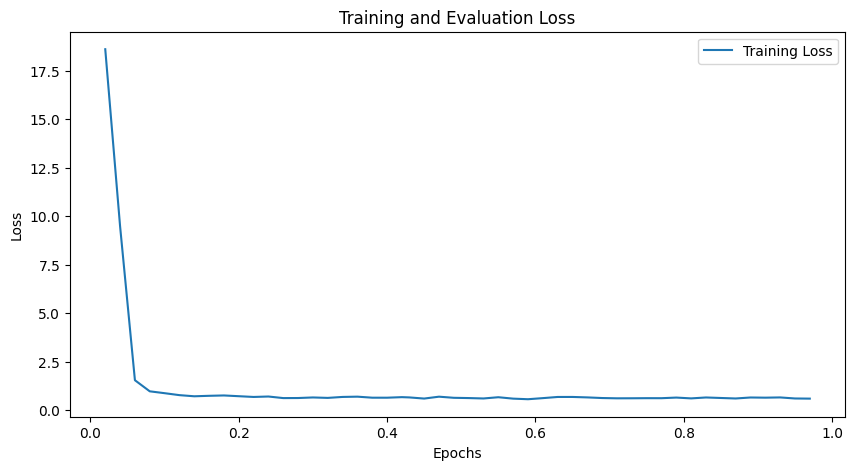

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history
train_losses = []
epochs = []

for log in history:
    train_losses.append(log['loss'])
    epochs.append(log['epoch'])

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

In [ ]:
trainer.model.save_pretrained(new_model)

# Push model to hugging face

In [ ]:
# Empty VRAM
del model
del peft_model
del trainer
import gc
gc.collect()
gc.collect()

In [ ]:
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
peft_model = PeftModel.from_pretrained(base_model, new_model)
peft_model = peft_model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
peft_model.push_to_hub(new_model)
tokenizer.push_to_hub(new_model)

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/baesad/t5-large-fine-tune/commit/721894bd98b1160ff719509ee5a6a0dcb47a7b2d', commit_message='Upload tokenizer', commit_description='', oid='721894bd98b1160ff719509ee5a6a0dcb47a7b2d', pr_url=None, pr_revision=None, pr_num=None)

# Evaluate

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("baesad/t5-large-fine-tune",
                                          model_max_length=512)
peft_model = AutoModelForSeq2SeqLM.from_pretrained("baesad/t5-large-fine-tune")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 948.2 kB/s eta 0:00:000:00:010m


In [ ]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=42c52a10e0f73f1782d25f21673b68517a30fb07b8dabb04789054d8dbb0915d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import evaluate
import numpy as np

rouge = evaluate.load('rouge')
exact_match_metric = evaluate.load("exact_match")

def compute_metrics(p):
    predictions, labels=p
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    predictions = np.argmax(predictions, axis=-1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge_metric = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    exact_match = exact_match_metric.compute(predictions=decoded_preds, references=decoded_labels)
    results = rouge_metric|exact_match
    return results

In [ ]:
peft_model.to(device)

trainer = Seq2SeqTrainer(
    model=peft_model,
    args=training_arguments,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics ,
    data_collator=data_collator
)

eval_results = trainer.evaluate(test_dataset.select(range(500)))
print(eval_results)

{'eval_loss': 0.47094470262527466, 'eval_rouge1': 0.570362392262171, 'eval_rouge2': 0.3326132069856533, 'eval_rougeL': 0.5663252616537381, 'eval_rougeLsum': 0.5677817380664534, 'eval_exact_match': 0.05, 'eval_runtime': 87.8179, 'eval_samples_per_second': 5.694, 'eval_steps_per_second': 1.423}


# Inference

In [ ]:
def extract_keyphrase(text):
  context=tokenizer([text], return_tensors="pt").to(device)
  output = peft_model.generate(**context, max_new_tokens=100)
  output = tokenizer.decode(output[0], skip_special_tokens=True)
  return output

In [ ]:
text = """
GPT-4o is our newest flagship model that provides GPT-4-level intelligence but is much faster and improves on its capabilities across text, voice, and vision.
Today, GPT-4o is much better than any existing model at understanding and discussing the images you share. For example, you can now take a picture of a menu in a different language and talk to GPT-4o to translate it, learn about the food's history and significance, and get recommendations. In the future, improvements will allow for more natural, real-time voice conversation and the ability to converse with ChatGPT via real-time video. For example, you could show ChatGPT a live sports game and ask it to explain the rules to you. We plan to launch a new Voice Mode with these new capabilities in an alpha in the coming weeks, with early access for Plus users as we roll out more broadly.
To make advanced AI more accessible and useful worldwide, GPT-4o's language capabilities are improved across quality and speed. ChatGPT also now supports more than 50 languages(opens in a new window) across sign-up and login, user settings, and more.
We are beginning to roll out GPT-4o to ChatGPT Plus and Team users, with availability for Enterprise users coming soon. We are also starting to roll out to ChatGPT Free with usage limits today. Plus users will have a message limit that is up to 5x greater than free users, and Team and Enterprise users will have even higher limits.
"""
print(f'Text: {text}')
keyphrase = extract_keyphrase(text)
print(f'\nKeyPhrase: {keyphrase}')

Text: 
GPT-4o is our newest flagship model that provides GPT-4-level intelligence but is much faster and improves on its capabilities across text, voice, and vision.
Today, GPT-4o is much better than any existing model at understanding and discussing the images you share. For example, you can now take a picture of a menu in a different language and talk to GPT-4o to translate it, learn about the food's history and significance, and get recommendations. In the future, improvements will allow for more natural, real-time voice conversation and the ability to converse with ChatGPT via real-time video. For example, you could show ChatGPT a live sports game and ask it to explain the rules to you. We plan to launch a new Voice Mode with these new capabilities in an alpha in the coming weeks, with early access for Plus users as we roll out more broadly.
To make advanced AI more accessible and useful worldwide, GPT-4o's language capabilities are improved across quality and speed. ChatGPT also n

In [ ]:
text = """
Build a model for extracting (generating) information from an input that can be either a text, an image, a voice file, or a video file. The architecture of the model should primarily consist of a Transformer-based Encoder-Decoder.
Choose a specific problem to  the practical application of the model:

Examples:
Describing dishes from a menu image
Extracting events and timings from a scanned image or a photo of a text document
Translating a menu from Vietnamese to English
...

Your submission should include the parts:
A section presenting the general theory and the theory of the model to be used
A section on data construction
A section on model training
A section on testing and evaluating accuracy"""
print(f'Text: {text}')
keyphrase = extract_keyphrase(text)
print(f'\nKeyPhrase: {keyphrase}')

Text: 
Build a model for extracting (generating) information from an input that can be either a text, an image, a voice file, or a video file. The architecture of the model should primarily consist of a Transformer-based Encoder-Decoder.
Choose a specific problem to  the practical application of the model:

Examples:
Describing dishes from a menu image
Extracting events and timings from a scanned image or a photo of a text document
Translating a menu from Vietnamese to English
...

Your submission should include the parts:
A section presenting the general theory and the theory of the model to be used
A section on data construction
A section on model training
A section on testing and evaluating accuracy

KeyPhrase: Extracting (generating) information; Transformer-based Encoder-Decoder


In [ ]:
text = """
Automatically extracting keyphrases from scholarly documents leads to a valuable concise representation that humans can understand and machines can process for tasks, such as information retrieval, article clustering and article classification. This paper is concerned with the parts of a scientific article that should be given as input to keyphrase extraction methods. Recent deep learning methods take titles and abstracts as input due to the increased computational complexity in processing long sequences, whereas traditional approaches can also work with full-texts. Titles and abstracts are dense in keyphrases, but often miss important aspects of the articles, while full-texts on the other hand are richer in keyphrases but much noisier. To address this trade-off, we propose the use of extractive summarization models on the full-texts of scholarly documents. Our empirical study on 3 article collections using 3 keyphrase extraction methods shows promising results.
"""
print(f'Text: {text}')
keyphrase = extract_keyphrase(text)
print(f'\nKeyPhrase: {keyphrase}')

Text: 
Automatically extracting keyphrases from scholarly documents leads to a valuable concise representation that humans can understand and machines can process for tasks, such as information retrieval, article clustering and article classification. This paper is concerned with the parts of a scientific article that should be given as input to keyphrase extraction methods. Recent deep learning methods take titles and abstracts as input due to the increased computational complexity in processing long sequences, whereas traditional approaches can also work with full-texts. Titles and abstracts are dense in keyphrases, but often miss important aspects of the articles, while full-texts on the other hand are richer in keyphrases but much noisier. To address this trade-off, we propose the use of extractive summarization models on the full-texts of scholarly documents. Our empirical study on 3 article collections using 3 keyphrase extraction methods shows promising results. 


KeyPhrase: ke